# Initial data loading and query on Airbnb data

The following steps:
- [Loading the data](#loading)
- [Part 1](#part1)
- [Part 2](#part2)
- [Part 3](#part3)

In [2]:
import datetime
import os
import pandas as pd
import pickle
import psycopg2
import csv
import numpy as np
from dotenv import find_dotenv, load_dotenv
from selenium import webdriver
import matplotlib.pyplot as plt


/Users/severinhatt/Virtualenvs/thinkful/base_plotting/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
def submit_to_pg(df,conn,table_name):
    cur = conn.cursor()
    columns_names =  b", ".join([a.encode() for a in df.columns])
    interpolate_string = ', '.join(['%s']*len(df.columns))
    listing_file =list(df.itertuples())
    args_str = b','.join(cur.mogrify("("+interpolate_string+")", x[1:]) for x in listing_file)
    insert_query = b"INSERT INTO "+table_name +b" ("+columns_names +b") VALUES " + args_str + b";"
    try:
        cur.execute(insert_query)
        conn.commit()
    except psycopg2.Error as e:
        print(e)
        print("error populating the table",columns_names)
        conn.rollback()

In [4]:
def create_temp_table_for(the_df,conn,table_name):
    basic = ""
    for i in the_df.columns:
        cols = i.split(" ")
        if len(cols) == 2:
            basic += i + ", "
        elif pd.core.dtypes.common.is_datetime64_ns_dtype(the_df[i]):
            basic += i +" date , "
        elif pd.core.dtypes.common.is_float_dtype(the_df[i]):
            basic += i +" float , "
        elif pd.core.dtypes.common.is_integer_dtype(the_df[i]):
            basic += i +" bigint , "
        else:
            basic += i +" text , "
        
    basic = basic[:-2]
    try:
        print("DROP TABLE IF EXISTS "+table_name+"  ;  CREATE TABLE "+table_name+"("+basic+")")
        cur.execute("DROP TABLE IF EXISTS "+table_name+"  ;  CREATE TABLE "+table_name+"("+basic+")")
        conn.commit()
    except psycopg2.Error as e:
        print(e)
        print("error","CREATE TABLE temp_table("+basic+")")
        conn.rollback()

In [11]:
load_dotenv(find_dotenv())



True

In [12]:
load_dotenv(find_dotenv())
password = os.environ.get("APP_DATABASE_PASSWORD")
database_name = 'airbnb'
try:
    conn = psycopg2.connect("dbname=%s user='postgres' host='localhost' password=%s"%(database_name,password))
except psycopg2.Error as e:
    print("I am unable to connect to the database")
    print(e)
    print(e.pgcode)
    print(e.pgerror)
    print(traceback.format_exc())
cur = conn.cursor()

## Loading Data

<a id="loading"></a>

In [13]:
#List files in local directory
files = [f for f in os.listdir('.') if os.path.isfile(f) and f[-6:] == "-2.csv"]

In [14]:
#Load in dataframes
df = dict()
for file in files:
    with open(file, 'rt') as f:
        df[file] = pd.read_csv(f).fillna("")


In [15]:
for table in df.keys():
    if "price" in df[table].columns:
        df[table]["value"] = df[table].price.str.extract('^\$([\d|\.]+)$').fillna(0)
        df[table]["value"] = pd.to_numeric(df[table]["value"])
    if "date" in df[table].columns:
        df[table]["date"] = pd.to_datetime(df[table]["date"],errors='coerce')

In [96]:
#Create Tables in PG database
#Load in PG Database
for key in df.keys():
    table_name = key[:-6]
    create_temp_table_for(df[key],conn,table_name)


DROP TABLE IF EXISTS reviews  ;  CREATE TABLE reviews(listing_id bigint , id bigint , date date , reviewer_id bigint , reviewer_name text , comments text )
DROP TABLE IF EXISTS listings  ;  CREATE TABLE listings(id bigint , listing_url text , scrape_id bigint , last_scraped text , name text , summary text , space text , description text , experiences_offered text , neighborhood_overview text , notes text , transit text , access text , interaction text , house_rules text , thumbnail_url text , medium_url text , picture_url text , xl_picture_url text , host_id bigint , host_url text , host_name text , host_since text , host_location text , host_about text , host_response_time text , host_response_rate text , host_acceptance_rate text , host_is_superhost text , host_thumbnail_url text , host_picture_url text , host_neighbourhood text , host_listings_count bigint , host_total_listings_count bigint , host_verifications text , host_has_profile_pic text , host_identity_verified text , street 

In [97]:
#Load in PG Database
for key in df.keys():
    table_name = key[:-6].encode()
    submit_to_pg(df[key],conn,table_name)

In [66]:
#Delete in necessary
for key in df.keys():
    table_name = key[:-6]
    cur.execute(f"delete from {table_name}")
    conn.commit()

<a id="part1"></a>
## Part 1 : What's the most expensive listing? What else can you tell me about the listing?



Just looking at listing table, they are 2 listings at \$999 :
- A villa on the Geneva Lake
- A Chalet in Villars

But looking at the actual price on the table calendar, we realize that only one location is actually available for rental at such a price.

So "chalet Merlchior" is a luxury Chalet Central Villars Sleeps up to 12 in 5 bedrooms. The host if not a superhost, come from London ... and much more details online.


In [16]:
query = """select * from listings where value in (SELECT max(value) FROM public.listings);"""
most_expensive = pd.io.sql.read_sql_query(query, conn)   
most_expensive

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,value
0,10145293,https://www.airbnb.com/rooms/10145293,20180828003430,2018-08-28,Luxury Chalet Central Villars Sleeps up to 12,"Chalet Melchior is a chic 5 bedroom, 4 bathroo...",An incredible living space for up to 12 people...,"Chalet Melchior is a chic 5 bedroom, 4 bathroo...",none,This is a fantastic base from which to explore...,...,,,f,f,strict_14_with_grace_period,f,f,4,0.03,999.0
1,21936129,https://www.airbnb.com/rooms/21936129,20180828003430,2018-08-28,NEW 3BD Luxury Villa on the Geneva Lake / Mont...,***** LUXURY UNIQUE LAKE HOME ***** Welcome...,The house went through several months of renov...,***** LUXURY UNIQUE LAKE HOME ***** Welcome...,none,,...,,,t,f,moderate,f,f,34,1.76,999.0


In [17]:
most_expensive.value

0    999.0
1    999.0
Name: value, dtype: float64

In [18]:
DRIVER = 'chromedriver'
driver = webdriver.Chrome(DRIVER)

In [19]:

index = 0
reference = most_expensive.listing_url[index]
driver.get(reference)
screenshot = driver.save_screenshot('my_screenshot_%i.png'%index)


In [20]:

index = 1
reference = most_expensive.listing_url[index]
driver.get(reference)
screenshot = driver.save_screenshot('my_screenshot_%i.png'%index)


<img src="my_screenshot_0.png" alt="Drawing" style="width: 500px;"/>
<img src="my_screenshot_1.png" alt="Drawing" style="width: 500px;"/>


In [21]:
pd.io.sql.read_sql_query("select distinct value, listing_id from calendar where value in (select max(value) from calendar )", conn)   
#print(most_expensive_cal.iloc[0])

,value,listing_id
0,999.0,10145293


In [22]:
query = """with most_expensive as
(select distinct price as max_price, listing_id from calendar where price in (select max(price) from calendar))
select max_price,* from listings inner join most_expensive on most_expensive.listing_id = listings.id;
"""
most_expensive_cal = pd.io.sql.read_sql_query(query, conn)   
print(most_expensive_cal.iloc[0])


max_price                                                                     $999.00
id                                                                           10145293
listing_url                                     https://www.airbnb.com/rooms/10145293
scrape_id                                                              20180828003430
last_scraped                                                               2018-08-28
name                                    Luxury Chalet Central Villars Sleeps up to 12
summary                             Chalet Melchior is a chic 5 bedroom, 4 bathroo...
space                               An incredible living space for up to 12 people...
description                         Chalet Melchior is a chic 5 bedroom, 4 bathroo...
experiences_offered                                                              none
neighborhood_overview               This is a fantastic base from which to explore...
notes                               We have been runni

<a id="part2"></a>
## Part 2 : What neighborhoods seem to be the most popular?

The comments seem to be all positive. We will measure the popularity of a listing by couting the number of reviews per listing.

To select the most popular neightbourhood, we will look at the average of the comments par listing (when this listing is commented).

This way the most popular in "Lavaux-Oron".


In [41]:
query = """
select neighbourhood_group_cleansed, cast(count(*) as float)/count(distinct listing_id) as comments_per_commented_listing,
cast(count(distinct listing_id) as float)/count(distinct listings.id) as listing_with_comment,count(*),
count(*),count(distinct listing_id),count(distinct listings.id) from listings 
left join reviews on reviews.listing_id = listings.id
group by neighbourhood_group_cleansed order by comments_per_commented_listing desc"""
popular_neighbouthood = pd.io.sql.read_sql_query(query, conn)   
popular_neighbouthood

,neighbourhood_group_cleansed,comments_per_commented_listing,listing_with_comment,count,count,count,count
0,Lavaux-Oron,17.192090,0.753191,3043,3043,177,235
1,Riviera-Pays-d'Enhaut,17.115768,0.774343,8575,8575,501,647
2,Nyon,15.645161,0.706840,3395,3395,217,307
3,Jura-Nord vaudois,14.951923,0.717241,1555,1555,104,145
4,Lausanne,14.444444,0.791934,12480,12480,864,1091
5,Broye-Vully,13.916667,0.813559,668,668,48,59
6,Gros-de-Vaud,12.073171,0.719298,495,495,41,57
7,Morges,11.481250,0.812183,1837,1837,160,197
8,Ouest lausannois,11.402010,0.780392,2269,2269,199,255
9,Aigle,11.025575,0.618671,4311,4311,391,632


In [25]:
pd.io.sql.read_sql_query("select * from reviews limit 10", conn)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7381,1852654,2012-07-31,1749769,Albert,"A cosy and stylish chalet flat, in an exceptio..."
1,7381,17757770,2014-08-17,11239044,Simon,Super semaine au chalet de Paula. Il est super...
2,7381,47459125,2015-09-19,19280725,Deborah,Paula was very welcoming. She responded immed...
3,7381,110403296,2016-10-26,100349483,Susan,Paula gave us a very accurate instructions on ...
4,7381,184285103,2017-08-19,26305890,Yves,Appartement dans un ancien chalet authentique ...
5,7381,187647037,2017-08-27,11121722,Monique,"Environnement très beau, typique et serin, bea..."
6,7381,214554819,2017-11-26,14048173,Mél,Nous avons passé un agréable week-end de ski d...
7,7381,294663089,2018-07-22,202565768,Lucie,La deco et l’agencement sont parfaits.\nTout e...
8,7381,299131996,2018-07-30,57517567,Emilien,Parfait pour un séjour calme en montagne
9,7381,302119099,2018-08-05,117468239,Benjamin,"Super séjour, endroit beau et calme avec une h..."


<a id="part3"></a>
## Part 3 : What time of year is the cheapest time to go to your city? What about the busiest?

Looking at the table **calendar** it is mostly forward looking : we do not have historical reservation.

There is also a date on the **reviews** table, but it is the data of the review, not the dates for the stay.

### Cheapest time in the city.

As the price for each rental vary, we first define a `min_max_price`  with the minimum and maximum price for each listing.

Usig that table, we calculate the proportion of the available rental (it is available per day) is actually the minimal price per month.

The month when the maximum proportion of "cheapest" price is available is November, closely followed by October and September.

### Busiest time in the city

As discussed we do not have access to the actual rentals, so we will infere the busiest time in the city based on the prices, typically, as the busiest time in the city there will be more demand than offer, so the price would be higher.

Tyring to infer the busiest moment just at looking at how much rentals are "available" could be misleading, because, during the busiest time some owner could prefer to user their properties, reducing the number of rental available.

The busiest month are July and August,


In [127]:
query = """
select min(date), max(date) from calendar limit 10"""
popular_neighbouthood = pd.io.sql.read_sql_query(query, conn)   
popular_neighbouthood

,min,max
0,2018-08-28,2019-08-27


In [104]:
pd.io.sql.read_sql_query("select * from reviews limit 3", conn)   

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7381,1852654,2012-07-31,1749769,Albert,"A cosy and stylish chalet flat, in an exceptio..."
1,7381,17757770,2014-08-17,11239044,Simon,Super semaine au chalet de Paula. Il est super...
2,7381,47459125,2015-09-19,19280725,Deborah,Paula was very welcoming. She responded immed...


In [117]:
query = """with min_max_value as
(select max(value) as max_value,min(value) as min_value, listing_id from calendar where available ='t' group by listing_id)

select EXTRACT(MONTH FROM date) as the_month, cast(count(nullif(min_value=value,false)) as float)/count(*) as percentage_min  
	from calendar inner join min_max_value on calendar.listing_id = min_max_value.listing_id
    where available = 't' and max_value > min_value
 group by the_month
 order by the_month asc"""
month_with_most_minimum_value = pd.io.sql.read_sql_query(query, conn)   
month_with_most_minimum_value

,the_month,percentage_min
0,1.0,0.357678
1,2.0,0.259599
2,3.0,0.284934
3,4.0,0.334434
4,5.0,0.431116
5,6.0,0.423100
6,7.0,0.250998
7,8.0,0.271557
8,9.0,0.737667
9,10.0,0.750297


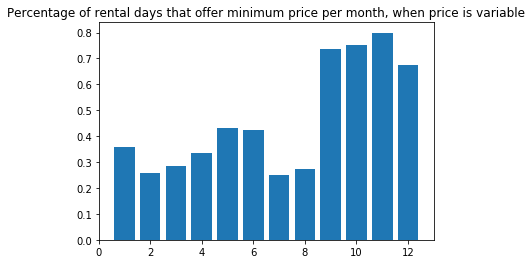

In [120]:
plt.bar(month_with_most_minimum_value.the_month,month_with_most_minimum_value.percentage_min);
plt.title("Percentage of rental days that offer minimum price per month, when price is variable");

In [130]:
query = """with min_max_value as
(select max(value) as max_value,min(value) as min_value, listing_id from calendar where available ='t' group by listing_id)

select EXTRACT(MONTH FROM date) as the_month, cast(count(nullif(max_value=value,false)) as float)/count(*) as percentage_max 
	from calendar inner join min_max_value on calendar.listing_id = min_max_value.listing_id
    where available = 't' and max_value > min_value
 group by the_month
 order by percentage_max desc"""
month_with_most_maximum_value = pd.io.sql.read_sql_query(query, conn)   
month_with_most_maximum_value

,the_month,percentage_max
0,7.0,0.364783
1,8.0,0.350539
2,6.0,0.319653
3,4.0,0.319025
4,5.0,0.313451
5,3.0,0.273073
6,2.0,0.258231
7,12.0,0.149907
8,1.0,0.141559
9,9.0,0.099843


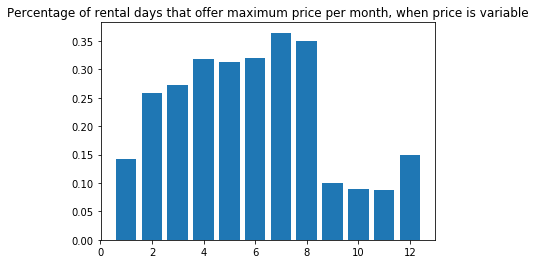

In [131]:
plt.bar(month_with_most_maximum_value.the_month,month_with_most_maximum_value.percentage_max);
plt.title("Percentage of rental days that offer maximum price per month, when price is variable");